In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import open3d as o3d
from tqdm import tqdm

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td
import events_utils.time_difference_2d as td2d
import events_utils.tum_vie as tum_dset
import events_utils.flow as flow_utils

from scipy.spatial.transform import Rotation as R

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
#define time range
t_start = 2.5
duration = 0.2
t_end = t_start + duration
shape = (180, 240)
dataset = "data/slider_close/"

In [4]:
events_raw = np.loadtxt(path + dataset + "events.txt", max_rows=10000000)

In [5]:
events_t = flt.filter_time(events_raw, t_start, t_end)

In [6]:
# patch_center = (80, 70)
# patch_size = 50
# patch_center = (90, 90)
# patch_size = 180
# shape = (patch_size, patch_size)
# events_p = flt.filter_patch(events_t, patch_center, patch_size)

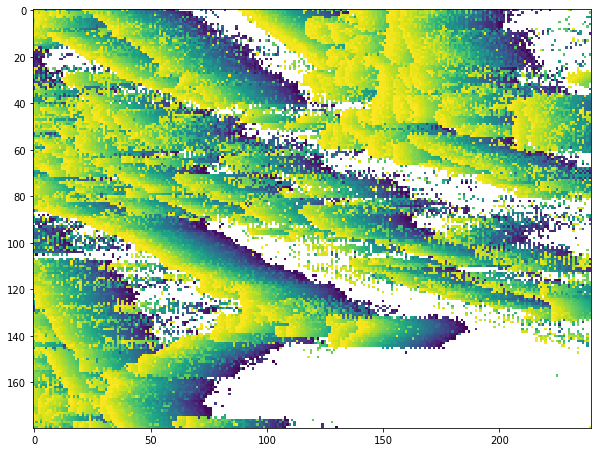

In [7]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events_t, shape, filter_polarity=False, polarity=1)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

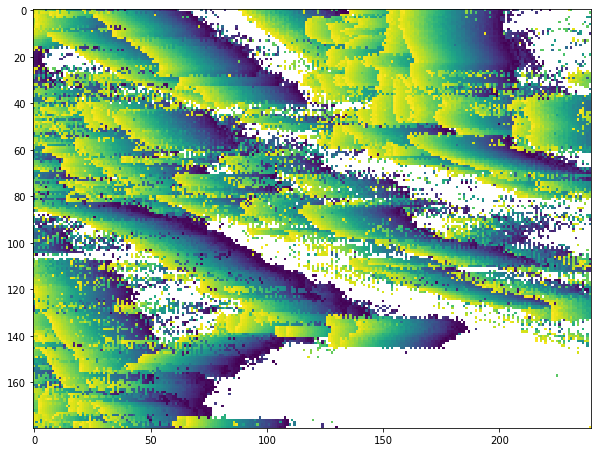

In [8]:
events = flt.filter_refract(events_t, 0.5)
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events, shape, filter_polarity=False, polarity=0)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

In [9]:
calib = np.loadtxt(path + dataset + "calib.txt")

In [10]:
poses = np.loadtxt(path + dataset + "groundtruth.txt")

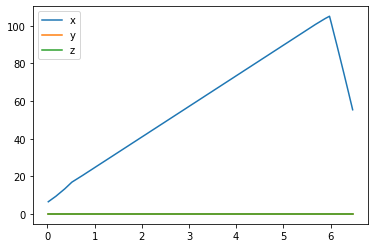

In [11]:
k = np.ones(100)
poses[:,1] = np.convolve(poses[:,1], k, mode="same")
poses[:,2] = np.convolve(poses[:,2], k, mode="same")
poses[:,3] = np.convolve(poses[:,3], k, mode="same")
poses[:,4] = np.convolve(poses[:,4], k, mode="same")
poses[:,5] = np.convolve(poses[:,5], k, mode="same")
poses[:,6] = np.convolve(poses[:,6], k, mode="same")
poses[:,7] = np.convolve(poses[:,7], k, mode="same")

plt.plot(poses[:,0], poses[:,1], label="x")
plt.plot(poses[:,0], poses[:,2], label="y")
plt.plot(poses[:,0], poses[:,3], label="z")
# plt.plot(poses[:,0], poses[:,4], label="q1")
# plt.plot(poses[:,0], poses[:,5], label="q2")
# plt.plot(poses[:,0], poses[:,6], label="q3")
# plt.plot(poses[:,0], poses[:,7], label="q4")
plt.legend()

In [12]:
U, V, std_u, std_v = td2d.measure_td2(events, shape, dist=2, px_range_pred=15, std_thr=0.012, mean_thr=0.01, start_delay=0.02, final_delay=0.1)

100%|██████████████████████████████████████████████████████████████████████████| 66800/66800 [00:07<00:00, 9437.21it/s]


In [13]:
m = np.sqrt(U**2 + V**2)

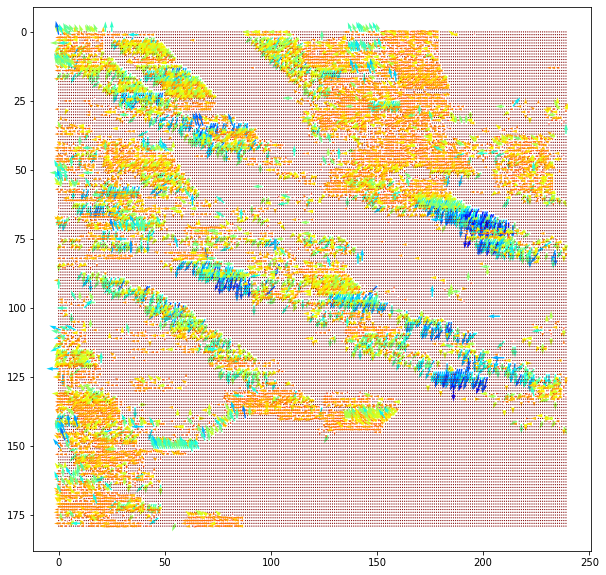

In [14]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(U, V, m, cmap="jet_r")
plt.gca().invert_yaxis()

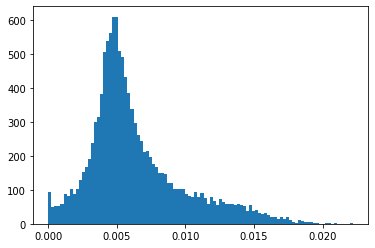

In [15]:
m_ma = np.ma.masked_where(np.isclose(m, 0.0), m)
plt.hist(m_ma.compressed(), 100);

In [16]:
C = [calib[2], calib[3]]

In [17]:
idx = np.searchsorted(poses[:, 0], t_start)
pose1 = poses[idx]
pose2 = poses[idx + 1]

ang1 = R.from_quat(pose1[4:]).as_euler("xyz")
ang2 = R.from_quat(pose2[4:]).as_euler("xyz")

vel = (ang2 - ang1) / (pose2[0] - pose1[0])

print(vel)

[0. 0. 0.]


In [18]:
ang_U, ang_V = flow_utils.get_angular_flow(vel, calib[0], C, shape)

c:\users\schiavaz\lava-nc\venv\lib\site-packages\matplotlib\quiver.py:689: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
c:\users\schiavaz\lava-nc\venv\lib\site-packages\matplotlib\quiver.py:689: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


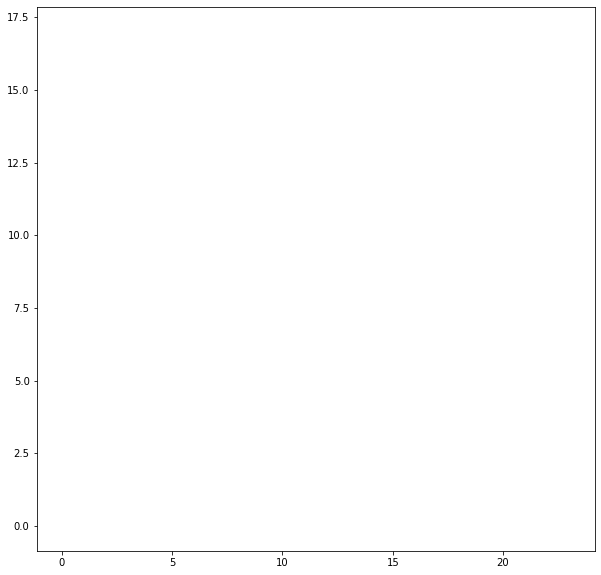

In [19]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(ang_U[::10, ::10], ang_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [20]:
idx = np.searchsorted(poses[:, 0], t_start)
pose1 = poses[idx]
pose2 = poses[idx + 1]

t1 = pose1[1:4]
t2 = pose2[1:4]

print(t1)
print(t2)

t_vel = (t2 - t1) #/ (pose2[0] - pose1[0])

print(t_vel)
print(pose2[0] - pose1[0])

[49.13945443  0.          0.        ]
[49.30213672  0.          0.        ]
[0.16268229 0.         0.        ]
0.009512643999999959


In [21]:
t_U, t_V = flow_utils.get_translational_flow(t_vel, calib[0], C, shape)

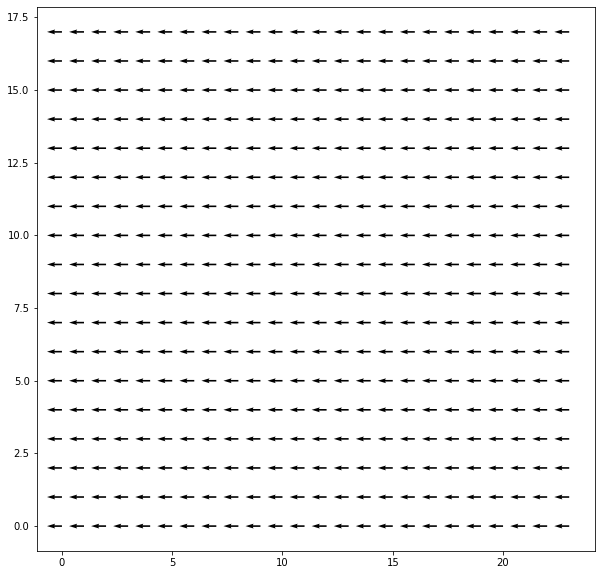

In [22]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(t_U[::10, ::10], t_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [23]:
flow_U = t_U + ang_U
flow_V = t_V + ang_V

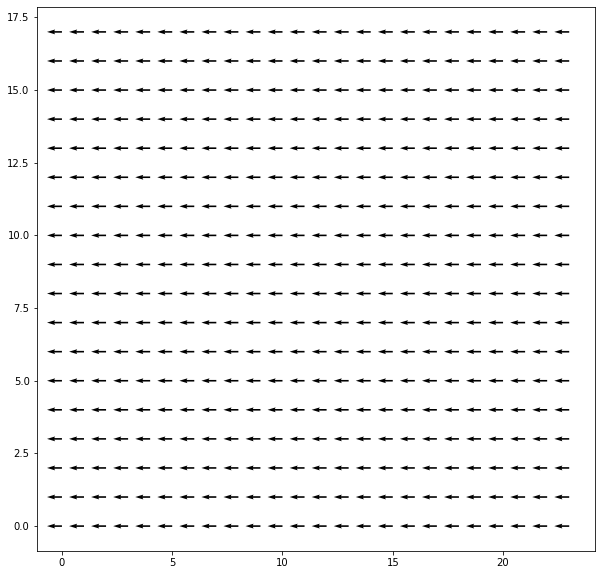

In [24]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(flow_U[::10, ::10], flow_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [219]:
test, test_u, test_v = td2d.extract_depth(shape, U, V, t_U, t_V)

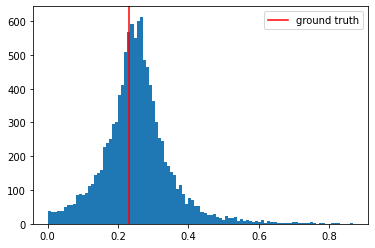

In [220]:
test_m = np.ma.masked_where(np.isclose(test, 0.0), test)
plt.hist(test_m.compressed(), 100);
plt.axvline(x=0.231, c="red", label="ground truth")
plt.legend()

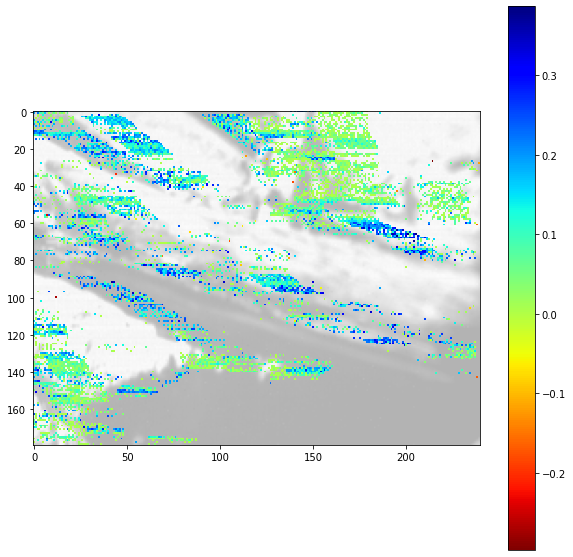

In [218]:
plt.figure(figsize=(10, 10))
img_gray = plt.imread(path + dataset + "images/frame_00000069.png")
plt.imshow(img_gray, alpha=0.3, cmap="gray")
m = plt.imshow(test_m, interpolation="none", cmap="jet_r")
plt.colorbar(m)

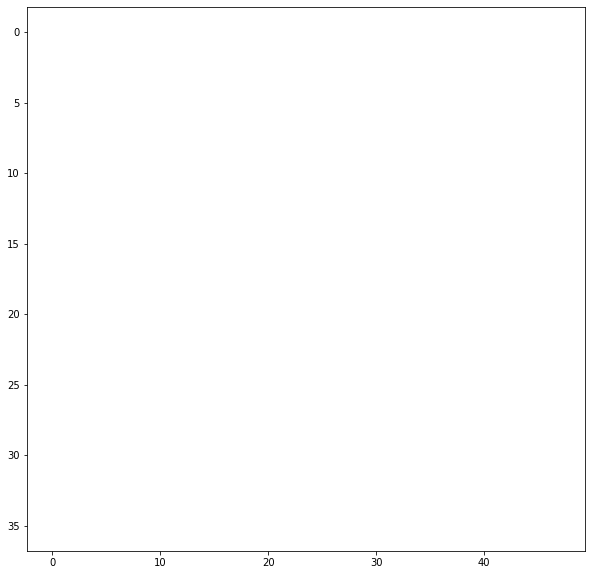

In [152]:
%matplotlib inline
plt.figure(figsize=(10, 10))
a = 5
m = np.sqrt(np.square(test_u) + np.square(test_v))
plt.quiver(test_u[::a, ::a], test_v[::a, ::a], m[::a, ::a], cmap="jet_r")
plt.gca().invert_yaxis()

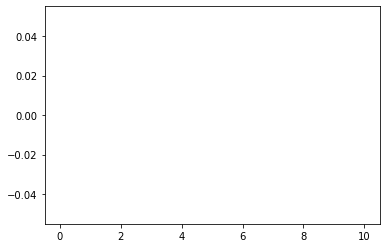

In [153]:
test_m = np.ma.masked_where(test == 0.0, test)
plt.hist(test_m.compressed(), 100, range=(0, 10));

In [154]:
# %matplotlib qt
# vis.visualize3d(test_m)

In [155]:
d = test_m

In [156]:
gt_d = 0.231

In [157]:
mean_error = np.mean(np.abs(d.compressed() - gt_d))
print(mean_error)

16706.68808691474


In [158]:
median_error = np.median(np.abs(d.compressed() - gt_d))
print(median_error)

11923.029339143503


In [159]:
p = mean_error / (d.compressed().max() - d.compressed().min())
print(p)

0.010432248625765271


In [160]:
np.ma.mean(d)

16706.919086914742

In [161]:
np.mean(d.compressed())

16706.919086914742

36